# Travel Insurance Prediction

In the following notebook, I'll be analyzing the Travel Insurance dataset from: https://www.kaggle.com/datasets/tejashvi14/travel-insurance-prediction-data .

The dataset contains results of the New Insurance Package offering in 2019 for almost 2000 customers, as well as informaiton on the customers they were offered to.

**Goal**: the company is hoping to optimize it's sales campaign by predicting which of the customers would be interestied in the new insurance package.


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

import warnings

import my_visual_func as my

In [2]:
palette = "muted"
custom_colors = sns.color_palette(palette, 2)
sns.set_palette(palette)

# for heatmaps
cmap = LinearSegmentedColormap.from_list(
    "custom_cmap", [custom_colors[0], "white", custom_colors[1]]
)

np.random.seed(48)

warnings.filterwarnings("ignore")

## 1. Data Cleaning


In [3]:
df = pd.read_csv("TravelInsurancePrediction.csv")
df = df.drop(columns=["Unnamed: 0"])

display(df.head())
display(df.shape)

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


(1987, 9)

In [4]:
print(df.info())
print("\nNull values by column:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Age                  1987 non-null   int64 
 1   Employment Type      1987 non-null   object
 2   GraduateOrNot        1987 non-null   object
 3   AnnualIncome         1987 non-null   int64 
 4   FamilyMembers        1987 non-null   int64 
 5   ChronicDiseases      1987 non-null   int64 
 6   FrequentFlyer        1987 non-null   object
 7   EverTravelledAbroad  1987 non-null   object
 8   TravelInsurance      1987 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 139.8+ KB
None

Null values by column:
Age                    0
Employment Type        0
GraduateOrNot          0
AnnualIncome           0
FamilyMembers          0
ChronicDiseases        0
FrequentFlyer          0
EverTravelledAbroad    0
TravelInsurance        0
dtype: int64


Fortunately, we don't have any missing values.

We seem to have several numeric columns describing the customers:

- **Age**
- **Annual Income** (in Ruupes)
- number of **Family Members**

We also have binary categorical variables, describing:

- **Employment Type** (Government vs Private sector/Self Employed)
- **College Graduate** status
- having **Chronic Diseases**
- being a **Frequent Flyer**
- having **Ever Traveled Abroad**
- if they purchased **Travel Insurance** or not


In [5]:
df.duplicated().sum()

738

It seems that we have many duplicates in our file, which is concerning, as < 2000 instances is not a lot of data, considering we have to split our data. Let's further inspect them.


In [6]:
all_duplicates = df.duplicated(keep=False)
duplicate_rows = df[all_duplicates]
duplicate_rows_sorted = duplicate_rows.sort_values(by=list(df.columns))

display(duplicate_rows_sorted.head(10))

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
184,25,Government Sector,Yes,750000,3,0,No,No,0
724,25,Government Sector,Yes,750000,3,0,No,No,0
629,25,Private Sector/Self Employed,No,600000,4,0,Yes,No,0
1013,25,Private Sector/Self Employed,No,600000,4,0,Yes,No,0
1898,25,Private Sector/Self Employed,No,600000,4,1,Yes,No,0
1905,25,Private Sector/Self Employed,No,600000,4,1,Yes,No,0
359,25,Private Sector/Self Employed,No,1150000,3,0,No,No,0
1315,25,Private Sector/Self Employed,No,1150000,3,0,No,No,0
1633,25,Private Sector/Self Employed,No,1150000,3,0,Yes,No,0
1645,25,Private Sector/Self Employed,No,1150000,3,0,Yes,No,0


Since the main goal of this project is to build a predictions model, and the amount of duplicates is suspiciously high, we will dropping the duplicates to avoid overfitting our prediction models.


In [7]:
df = df.drop_duplicates()

In [8]:
X = df.copy().drop(columns=["TravelInsurance"])
y = df["TravelInsurance"]

X_train, X_vt, y_train, y_vt = train_test_split(X, y, test_size=0.3, random_state=48)

X_validation, X_test, y_validation, y_test = train_test_split(
    X_vt, y_vt, test_size=0.5, random_state=48
)

print(
    f"Training set: {X_train.shape}, {y_train.shape} \nValidation set: {X_validation.shape}, {y_validation.shape} \nTest set: {X_test.shape}, {y_test.shape} "
)

df = X_train.copy()
df["TravelInsurance"] = y_train
df.head()

Training set: (874, 8), (874,) 
Validation set: (187, 8), (187,) 
Test set: (188, 8), (188,) 


,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
526,31,Private Sector/Self Employed,Yes,1100000,4,1,No,No,0
205,29,Private Sector/Self Employed,Yes,1150000,4,1,No,Yes,0
1635,31,Private Sector/Self Employed,Yes,1250000,5,0,No,No,0
8,28,Private Sector/Self Employed,Yes,1450000,6,1,Yes,Yes,1
1824,28,Private Sector/Self Employed,Yes,800000,4,1,Yes,No,0


In [9]:
looks_categorical = [
    "Employment Type",
    "GraduateOrNot",
    "ChronicDiseases",
    "FrequentFlyer",
    "EverTravelledAbroad",
    "TravelInsurance",
]

for col in looks_categorical:
    print(f"{col}: {df[col].unique()}")

Employment Type: ['Private Sector/Self Employed' 'Government Sector']
GraduateOrNot: ['Yes' 'No']
ChronicDiseases: [1 0]
FrequentFlyer: ['No' 'Yes']
EverTravelledAbroad: ['No' 'Yes']
TravelInsurance: [0 1]


Let's standartize the categorical variables.


In [10]:
def prep_df(df):
    df = df.rename(columns={"Employment Type": "InGovernmentSector"})
    df["InGovernmentSector"] = df["InGovernmentSector"].map(
        {"Government Sector": 1, "Private Sector/Self Employed": 0}
    )
    df["GraduateOrNot"] = df["GraduateOrNot"].map({"Yes": 1, "No": 0})
    df["FrequentFlyer"] = df["FrequentFlyer"].map({"Yes": 1, "No": 0})
    df["EverTravelledAbroad"] = df["EverTravelledAbroad"].map({"Yes": 1, "No": 0})

    return df

In [11]:
X_train = prep_df(X_train)
X_validation = prep_df(X_validation)
X_test = prep_df(X_test)

df = prep_df(df)

looks_categorical = ["InGovernmentSector"] + looks_categorical[1:]

## 2. EDA


### 2.1. Our customers in 2019

Lets begin by exploring what was our target clientel for this travel insurance package in 2019.


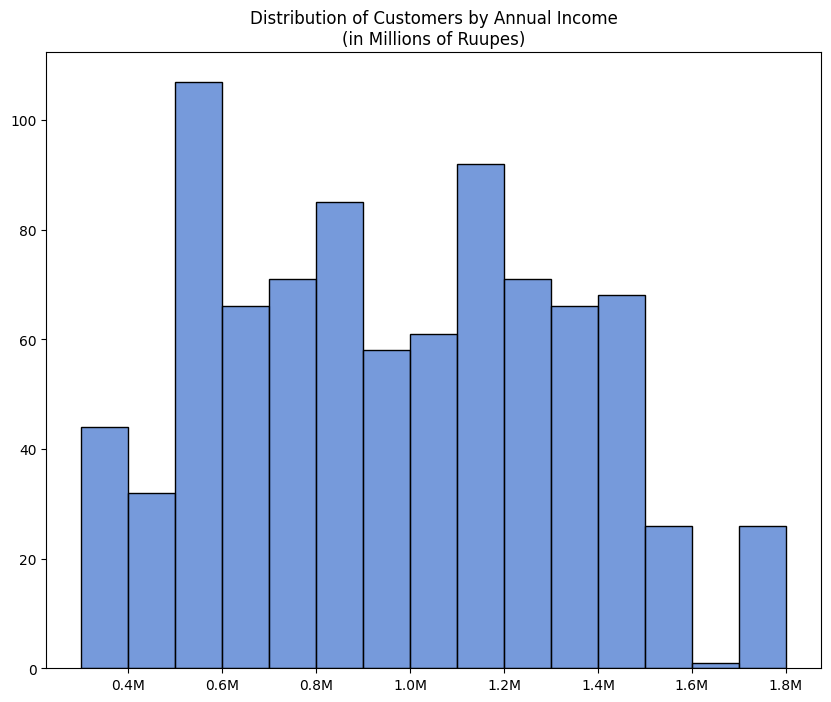

In [12]:
plt.figure(figsize=(10, 8))

sns.histplot(data=df, x="AnnualIncome", bins=15)
plt.title("Distribution of Customers by Annual Income\n(in Millions of Ruupes)")

plt.xlabel("")
plt.ylabel("")
plt.gca().xaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, pos: my.millions_formatter(x, pos, decimals=1))
)

plt.show()

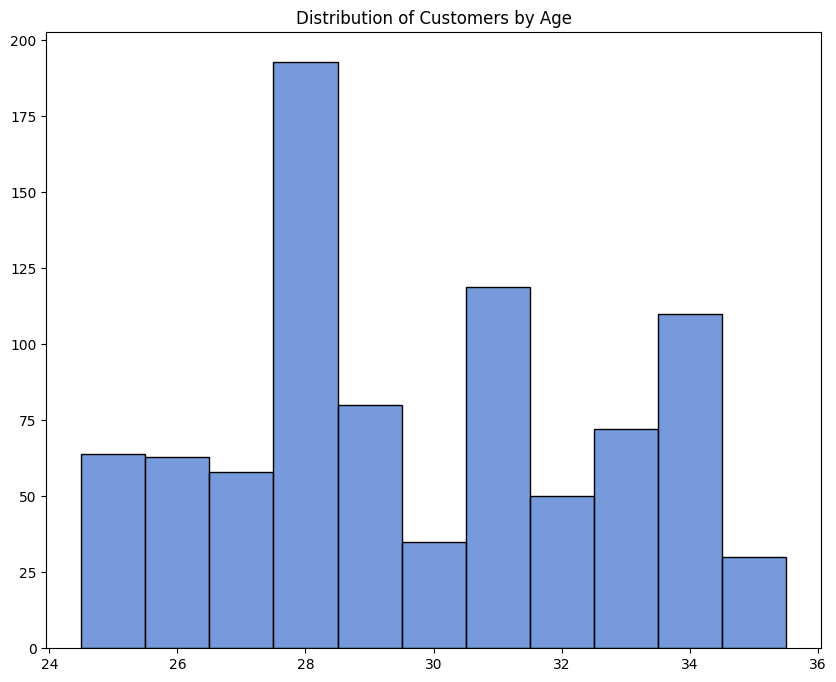

In [13]:
age_bins = np.arange(df.Age.min() - 0.5, df.Age.max() + 1.5)

plt.figure(figsize=(10, 8))
sns.histplot(data=df, x="Age", bins=age_bins)

plt.title("Distribution of Customers by Age")
plt.xlabel("")
plt.ylabel("")

plt.show()

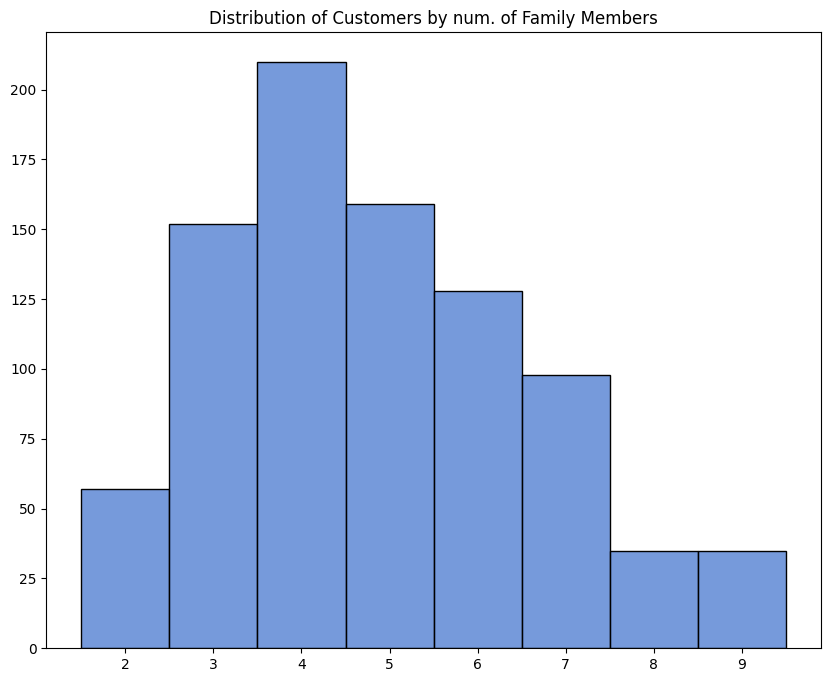

In [14]:
family_bins = np.arange(df.FamilyMembers.min() - 0.5, df.FamilyMembers.max() + 1.5)

plt.figure(figsize=(10, 8))
sns.histplot(data=df, x="FamilyMembers", bins=family_bins)

plt.title("Distribution of Customers by num. of Family Members")
plt.xlabel("")
plt.ylabel("")

plt.show()

In [15]:
df.describe()

,Age,InGovernmentSector,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
count,874.000000,874.000000,874.000000,8.740000e+02,874.000000,874.000000,874.000000,874.000000,874.000000
mean,29.786041,0.296339,0.831808,9.362128e+05,4.867277,0.326087,0.229977,0.197941,0.391304
std,2.915179,0.456904,0.374251,3.631925e+05,1.762081,0.469048,0.421059,0.398675,0.488322
min,25.000000,0.000000,0.000000,3.000000e+05,2.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,0.000000,1.000000,6.000000e+05,4.000000,0.000000,0.000000,0.000000,0.000000
50%,29.000000,0.000000,1.000000,9.000000e+05,5.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,1.000000,1.000000,1.237500e+06,6.000000,1.000000,0.000000,0.000000,1.000000
max,35.000000,1.000000,1.000000,1.800000e+06,9.000000,1.000000,1.000000,1.000000,1.000000


In our 2019 Travel Insurance offering, we were targeting customers with the following traits:

- age of 25-35 years;
- ~30% working in the Government sector, while the 70% were working in the Private Sector or were self-employed;
- Majority (~83%) were College graduates;
- Average annual income of ~935'000 Rupees;
- 32.6% had at least one chronic disease;
- 23% were frequent flyers;
- Only ~20% have ever travelled abroad.

Our convertion rate in 2019 for these customers was 39.1%.


### 2.2. Customers analysis continued (Multivariate)


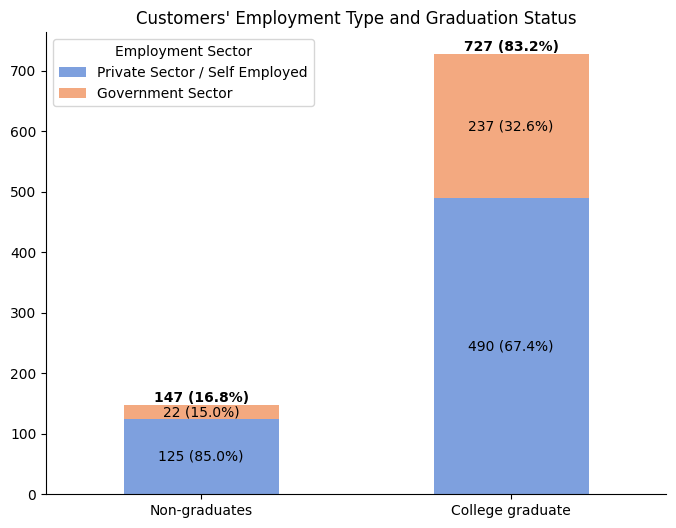

In [16]:
my.plot_stacked_bar_chart(df, "GraduateOrNot", "InGovernmentSector")

ax = plt.gca()
ax.set_xticklabels(["Non-graduates", "College graduate"])
plt.legend(
    title="Employment Sector",
    labels=["Private Sector / Self Employed", "Government Sector"],
)

plt.xlabel("")
plt.title("Customers' Employment Type and Graduation Status")

plt.show()

From the barchart above, we see that most of our customers are college graduates, working in the private sectore or are self employed. Interestingly, most of our customers that are working in government sector are college graduates, indicating that there could be a stronger preference for college graduates in the public sector.


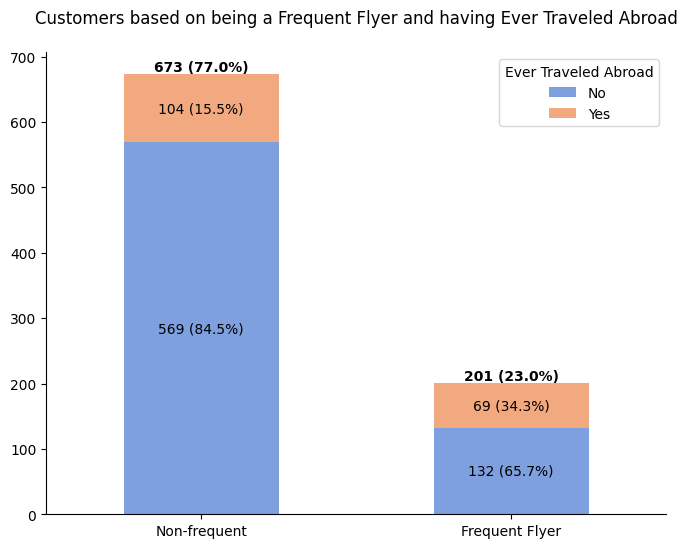

In [17]:
my.plot_stacked_bar_chart(df, "FrequentFlyer", "EverTravelledAbroad")

ax = plt.gca()
ax.set_xticklabels(["Non-frequent", "Frequent Flyer"])
plt.legend(title="Ever Traveled Abroad", labels=["No", "Yes"])

plt.xlabel("")
plt.title("Customers based on being a Frequent Flyer and having Ever Traveled Abroad\n")

plt.show()

Most customers aren't frequent flyers and haven't ever traveled abroad. Unsuprisingly, a larger proportion of frequent flyers have ever travelled abroad compared to non-frequent flyers. However, more than half (65.7%) of frequent flyers have never traveled abroad.


<Figure size 1200x800 with 0 Axes>

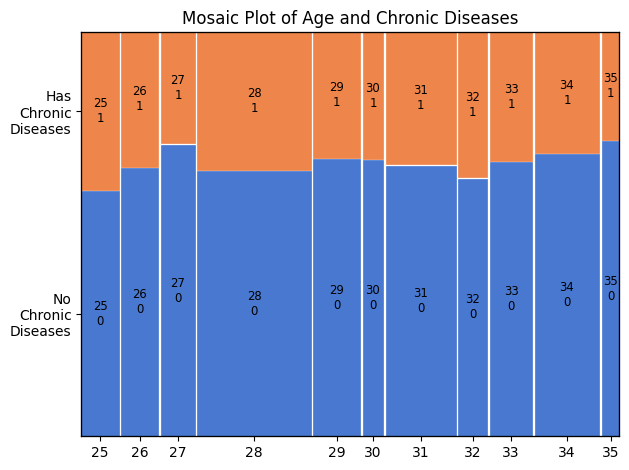

In [18]:
df_sorted = df.copy()
df_sorted.sort_values("Age", inplace=True)
df_sorted["Age_str"] = pd.Categorical(
    df_sorted["Age"], ordered=True, categories=sorted(df_sorted["Age"].unique())
).astype(str)

color_dict = {
    str(value): color
    for value, color in zip(df_sorted["ChronicDiseases"].unique(), custom_colors)
}


plt.figure(figsize=(12, 8))
mosaic(
    df_sorted,
    ["Age_str", "ChronicDiseases"],
    title="Mosaic Plot of Age and Chronic Diseases",
    properties=lambda key: {
        "color": color_dict[str(key[1])],
        "edgecolor": "white",
        "linewidth": 0.5,
    },
)

ax = plt.gca()
ax.set_yticklabels(["No\nChronic\nDiseases", "Has\nChronic\nDiseases"])
plt.tight_layout()
plt.show()

There doesn't seem to be any strong relationship between customer **age** and having **chronic diseases**. We will formally test this in section 3.2.

Now let's take a look if there is any correlation between our features.


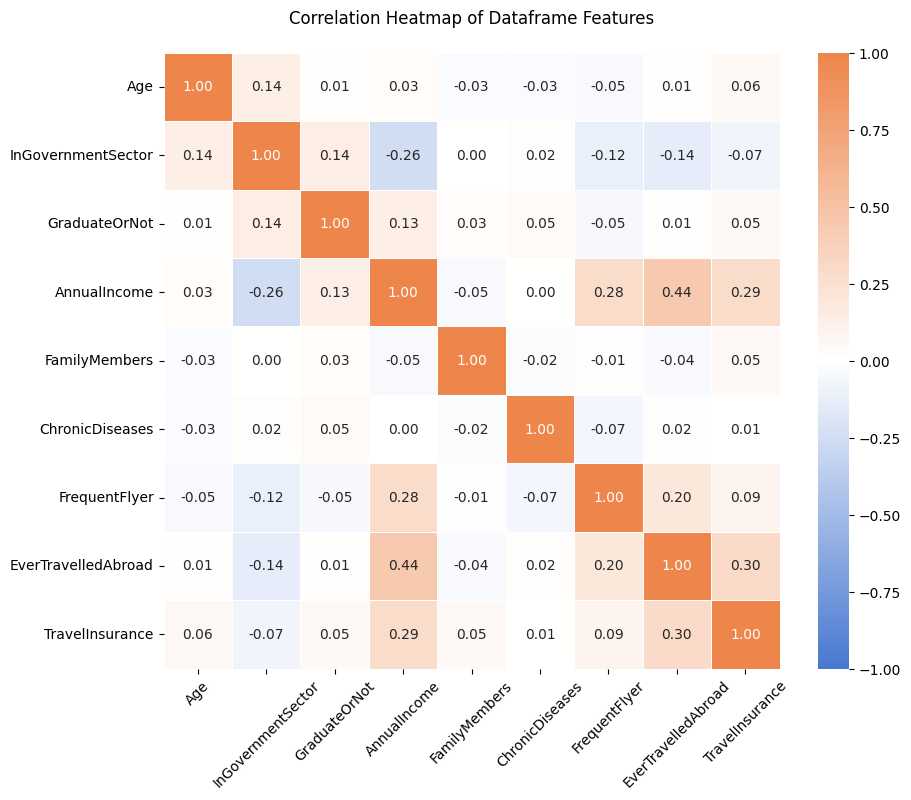

In [19]:
corr = df.corr(method="spearman")

plt.figure(figsize=(10, 8))

sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    square=True,
    linewidths=0.5,
    vmin=-1,
    vmax=1,
)

plt.title("Correlation Heatmap of Dataframe Features\n")
plt.xticks(rotation=45)

plt.show()

In our dataset, there doesn't seem to be any strong correlation between any variables. There is some weak positive correlation between **Annual Income**, and:

- having **Ever Travelled Abroad**,
- buying our **Travel Insurance** (our target feature),
- being a **Frequent Flyer**,
- working in the **Private Sector (or Self-Employed)** (a.k.a. _not_ working in the **Government sector**).

Looking at our target feature **Travell Insurance**, there's also some weak positive correlation with having **Ever Travelled Abroad**.

Since correlations are not strong and we are aiming for predictive model (accuracy > explainability), multicollinearity should not be a problem.


### 2.3. Travel insurance buyers versus non-buyers

In the following section we will be looking at our customers through the lense of purchasing our new travel insurance package.


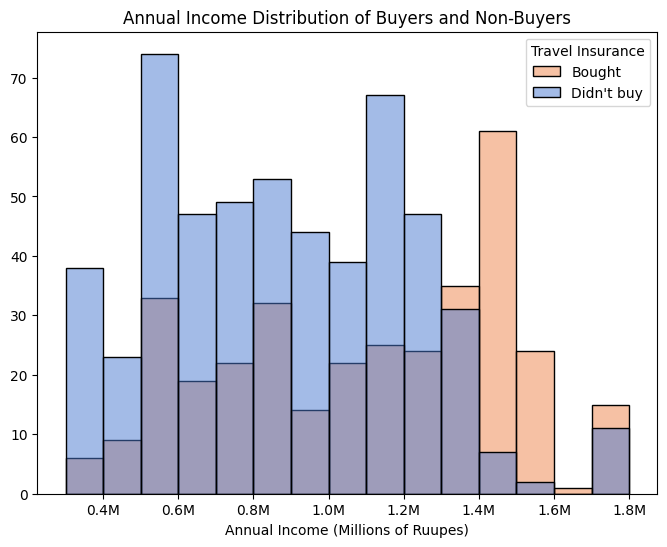

In [20]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x="AnnualIncome", bins=15, hue="TravelInsurance")

plt.title("Annual Income Distribution of Buyers and Non-Buyers")
plt.xlabel("Annual Income (Millions of Ruupes)")
plt.ylabel("")
plt.gca().xaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, pos: my.millions_formatter(x, pos, decimals=1))
)

plt.legend(title="Travel Insurance", labels=["Bought", "Didn't buy"])

plt.show()

There is clear difference, and the proportions flip when Annual income is > 1.3M Ruupes.


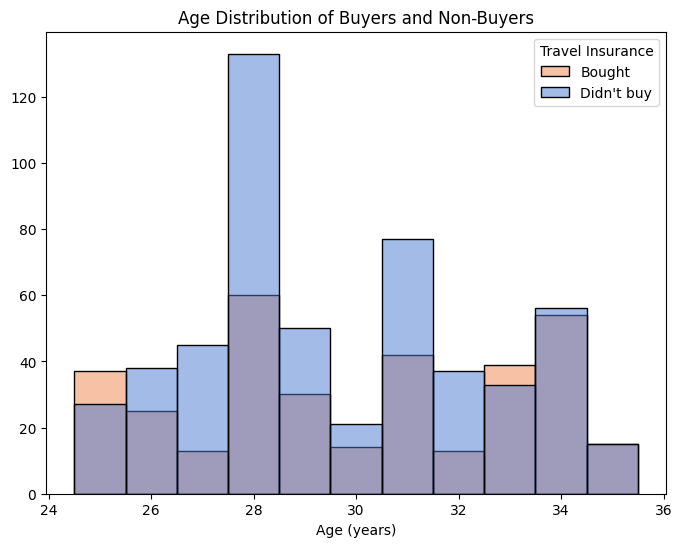

In [21]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x="Age", bins=age_bins, hue="TravelInsurance")

plt.title("Age Distribution of Buyers and Non-Buyers")
plt.xlabel("Age (years)")
plt.ylabel("")
plt.legend(title="Travel Insurance", labels=["Bought", "Didn't buy"])

plt.show()

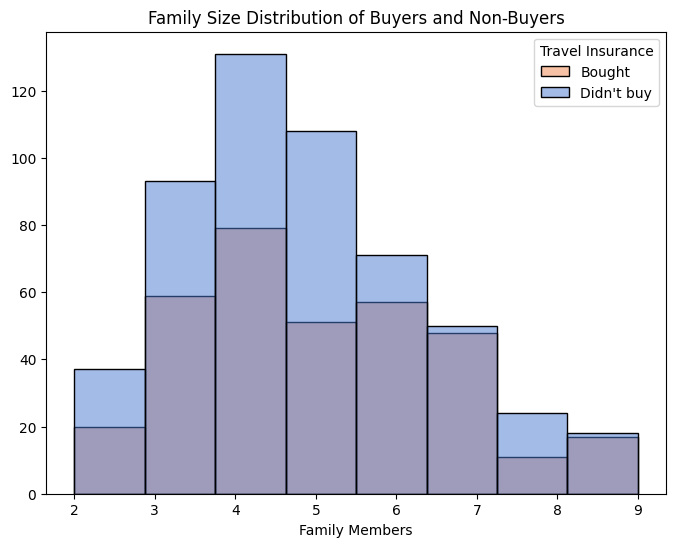

In [22]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x="FamilyMembers", bins=8, hue="TravelInsurance")

plt.title("Family Size Distribution of Buyers and Non-Buyers")
plt.xlabel("Family Members")
plt.ylabel("")
plt.legend(title="Travel Insurance", labels=["Bought", "Didn't buy"])

plt.show()

Number of Family Members seems to follow a normal distribution, that is slightly rightly-skewed. Intristingly, it seems that with the number of family members increasing, so does the likelyhood of purchasing travel insurance as well.


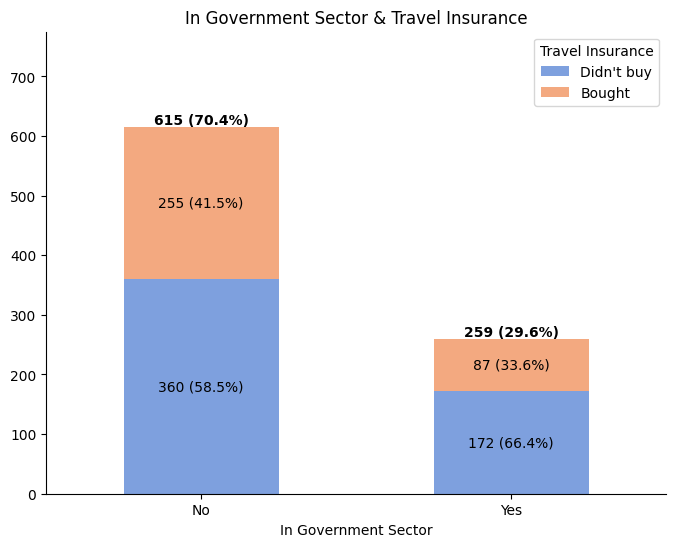

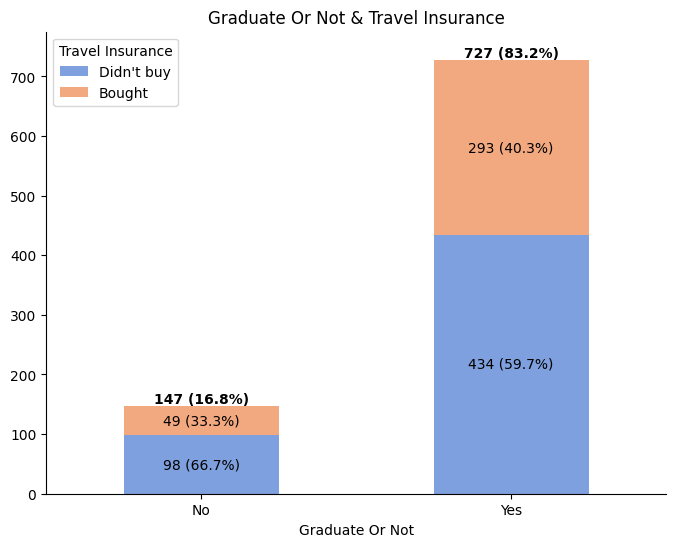

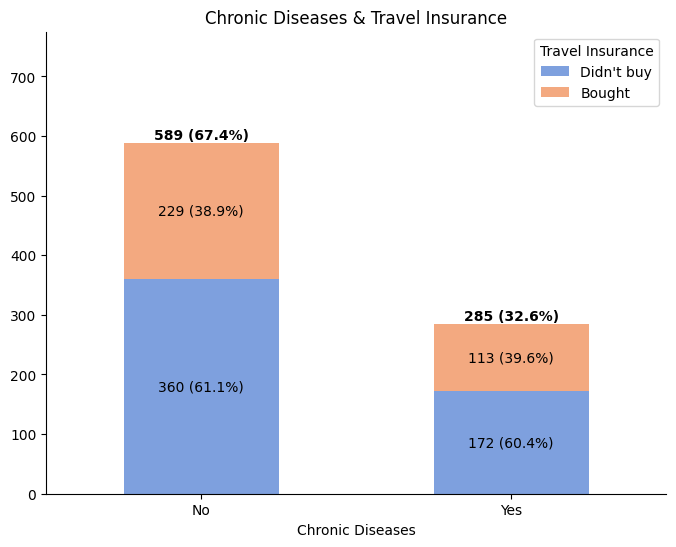

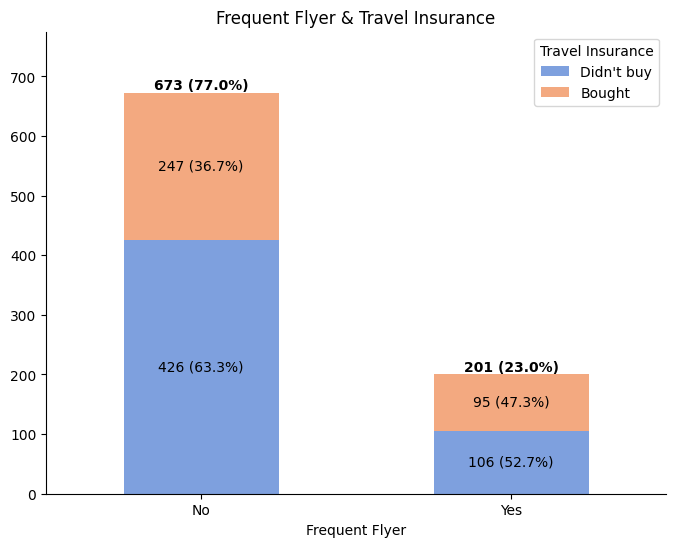

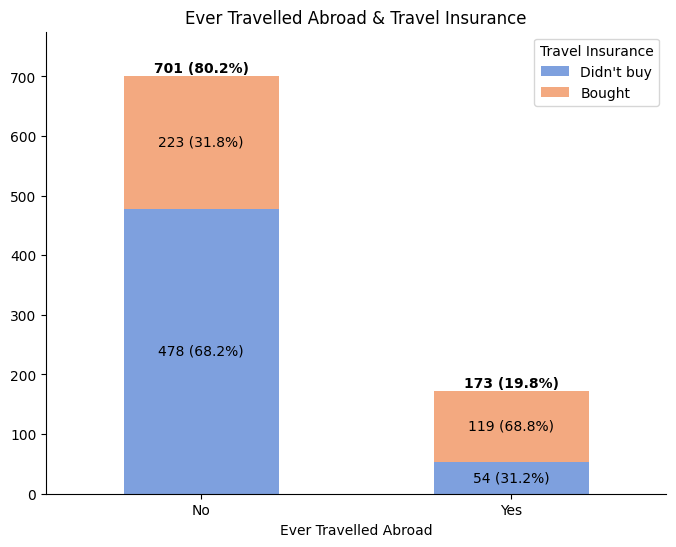

In [23]:
for col in looks_categorical[:-1]:
    my.plot_stacked_bar_chart(df=df, category_col=col, target_col="TravelInsurance")

    plt.legend(title="Travel Insurance", labels=["Didn't buy", "Bought"])
    plt.ylim(0, 775)

    col_formatted = my.camel_case_to_title(col)

    plt.title(f"{col_formatted} & Travel Insurance")

    locs, labels = plt.xticks()
    plt.xticks(locs, ["No", "Yes"][: len(locs)])
    plt.xlabel(col_formatted)

    plt.show()

In [24]:
display(df[df["TravelInsurance"] == 1].describe())
display(df[df["TravelInsurance"] == 0].describe())

,Age,InGovernmentSector,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
count,342.000000,342.000000,342.000000,3.420000e+02,342.000000,342.000000,342.000000,342.000000,342.0
mean,30.005848,0.254386,0.856725,1.066374e+06,4.991228,0.330409,0.277778,0.347953,1.0
std,3.155774,0.436154,0.350866,3.752548e+05,1.808236,0.471050,0.448559,0.477019,0.0
min,25.000000,0.000000,0.000000,3.000000e+05,2.000000,0.000000,0.000000,0.000000,1.0
25%,28.000000,0.000000,1.000000,7.500000e+05,4.000000,0.000000,0.000000,0.000000,1.0
50%,30.000000,0.000000,1.000000,1.100000e+06,5.000000,0.000000,0.000000,0.000000,1.0
75%,33.000000,1.000000,1.000000,1.400000e+06,6.000000,1.000000,1.000000,1.000000,1.0
max,35.000000,1.000000,1.000000,1.800000e+06,9.000000,1.000000,1.000000,1.000000,1.0


,Age,InGovernmentSector,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
count,532.000000,532.000000,532.000000,5.320000e+02,532.000000,532.000000,532.000000,532.000000,532.0
mean,29.644737,0.323308,0.815789,8.525376e+05,4.787594,0.323308,0.199248,0.101504,0.0
std,2.743201,0.468180,0.388021,3.294093e+05,1.728785,0.468180,0.399811,0.302279,0.0
min,25.000000,0.000000,0.000000,3.000000e+05,2.000000,0.000000,0.000000,0.000000,0.0
25%,28.000000,0.000000,1.000000,5.500000e+05,4.000000,0.000000,0.000000,0.000000,0.0
50%,29.000000,0.000000,1.000000,8.500000e+05,5.000000,0.000000,0.000000,0.000000,0.0
75%,32.000000,1.000000,1.000000,1.100000e+06,6.000000,1.000000,0.000000,0.000000,0.0
max,35.000000,1.000000,1.000000,1.750000e+06,9.000000,1.000000,1.000000,1.000000,0.0


Customers that have purchased our travel insurance were:

- more likely to work in the Private Sector and have higher Annual Income
- more likely to be a Frequent Flyer and having Ever Travelled Aborad.


## 3. Statistical Inference


### 3.1. Customers who have ever travelled abroad have higher income


In the Exploratory Data Analysis, we saw that both Annual Income and having Ever Traveled Abroad have weak ppositive correlation with purchasing travel insurance. In this section, we will be testing if the annual income is statistically significantly higher than for customers who have not traveled abroad.

**$H_{1N}$**: The mean annual income of customers who have travelled abroad is less than or equal to the mean annual income of customers who have not travelled abroad.

**$H_{1A}$**: The mean annual income of customers who have travelled abroad is greater than the mean annual income of customers who have not travelled abroad.

**_Population_**: all customers in our (training) dataset.

**_Statistical test_**: One-way Welch’s t-test, since variances are not equal.

Since the distribution of annual income is not normal, we have to apply Central Limit Theorem.


In [25]:
alpha = 0.01

In [26]:
not_traveled_abroad = df[df["EverTravelledAbroad"] == 0]["AnnualIncome"]
traveled_abroad = df[df["EverTravelledAbroad"] == 1]["AnnualIncome"]

t_stat, p_val = stats.ttest_ind(
    traveled_abroad, not_traveled_abroad, equal_var=False, alternative="greater"
)

print(f"T-statistic: {t_stat}, P-value: {p_val:.6f}")
print(f"P-value below required treshold: {p_val < alpha}")

T-statistic: 14.780703428073657, P-value: 0.000000
P-value below required treshold: True


With p-value below 0.01, we reject the Null hypothesis, and state that the average annual income of customers who have ever travelled abroad is higher than the average of those who didn't. Let's further inspect the difference between groups.


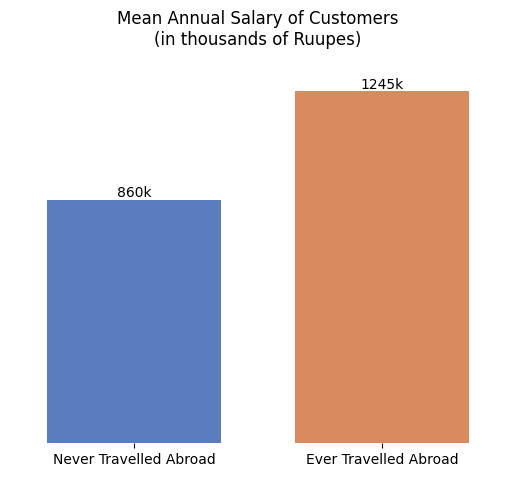

In [27]:
income_data = {
    "Category": ["Never Travelled Abroad", "Ever Travelled Abroad"],
    "Annual Income": [not_traveled_abroad.mean(), traveled_abroad.mean()],
}

income_data = pd.DataFrame(income_data)

my.plot_barchart(income_data, percent=False, order=False, scale="thousands")
plt.title("Mean Annual Salary of Customers\n(in thousands of Ruupes)\n")
plt.show()

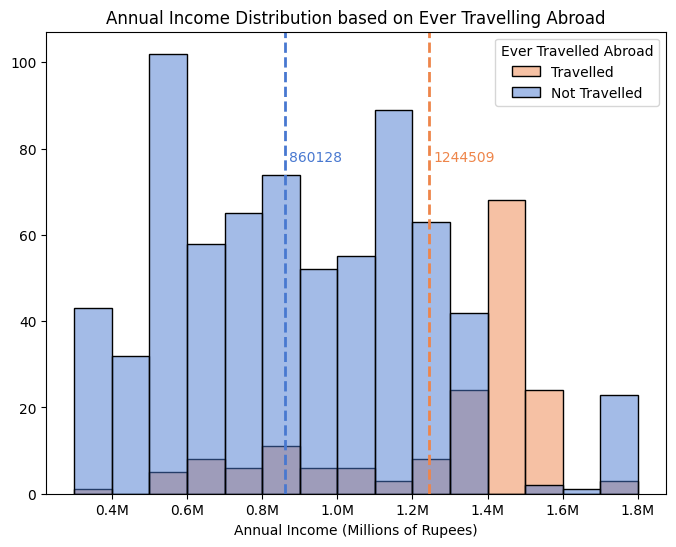

In [28]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x="AnnualIncome", bins=15, hue="EverTravelledAbroad", kde=False)

plt.title("Annual Income Distribution based on Ever Travelling Abroad")
plt.xlabel("Annual Income (Millions of Rupees)")
plt.ylabel("")
plt.gca().xaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, pos: my.millions_formatter(x, pos, decimals=1))
)
plt.legend(title="Ever Travelled Abroad", labels=["Travelled", "Not Travelled"])

mean_income_not_traveled = not_traveled_abroad.mean()
mean_income_traveled = traveled_abroad.mean()


plt.axvline(
    mean_income_not_traveled, color=custom_colors[0], linestyle="dashed", linewidth=2
)
plt.axvline(
    mean_income_traveled, color=custom_colors[1], linestyle="dashed", linewidth=2
)


plt.text(
    mean_income_not_traveled + 10**4,
    plt.gca().get_ylim()[1] - 30,
    f"{mean_income_not_traveled:.0f}",
    color=custom_colors[0],
    ha="left",
)

plt.text(
    mean_income_traveled + 10**4,
    plt.gca().get_ylim()[1] - 30,
    f"{mean_income_traveled:.0f}",
    color=custom_colors[1],
    ha="left",
)

plt.show()

In [29]:
print(
    f"Customers who have ever travelled abroad, on average, have {(mean_income_traveled - mean_income_not_traveled) / mean_income_not_traveled * 100:.1f}% higher annual income."
)

Customers who have ever travelled abroad, on average, have 44.7% higher annual income.


From the barchart and histogram above, we see that customers who have ever travelled abroad in fact have higher annual income (45%).


### 3.2. Relationship between Age and Chronic Diseases for customers (25-35 years of age).


In the EDA, from the Mosaic plot we didn't see patterns between Age and chronic diseases for this customer segment. To ensure that is the case, we will conduct a hypothesis test by comparing the mean age of two groups.

**$H_{2N}$**: There is no statistically significant difference in mean age of customers with and without chronic diseases.

**$H_{2A}$**: There is statistically significant difference in mean age of customers with and without chronic diseases.

**_Population_**: all customers in our (training) dataset. All customers are 25 - 35 years of age. Group 1: customers without chronic diseases. Group 2: customers with chronic diseases.

**_Statistical test_**: two-way t-test.

Since the distribution of age is not normal, we have to apply Central Limit Theorem.


In [30]:
alpha = 0.01

In [31]:
no_disease = df[df["ChronicDiseases"] == 0]["Age"]
disease = df[df["ChronicDiseases"] == 1]["Age"]

t_stat, p_val = stats.ttest_ind(
    no_disease, disease, equal_var=True, alternative="two-sided"
)

print(f"T-statistic: {t_stat}, P-value: {p_val:.6f}")
print(f"P-value below required treshold: {p_val < alpha}")

T-statistic: 0.9162780507764248, P-value: 0.359774
P-value below required treshold: False


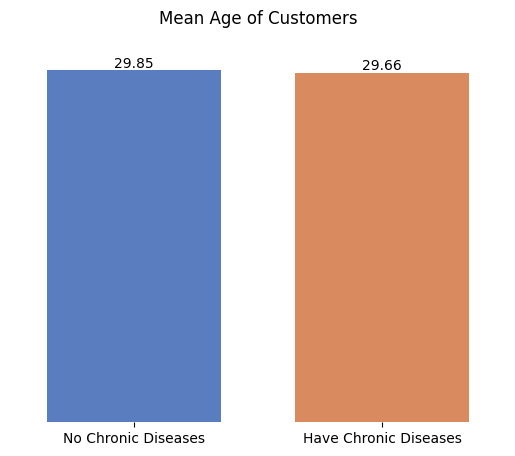

In [32]:
diseases_data = {
    "Category": ["No Chronic Diseases", "Have Chronic Diseases"],
    "Age": [no_disease.mean(), disease.mean()],
}

diseases_data = pd.DataFrame(diseases_data)

my.plot_barchart(diseases_data, percent=False, order=False, decimals=2)
plt.title("Mean Age of Customers\n")
plt.show()

With p-value of above 0.01 we fail to reject the null hypothesis. It seems that Age is not a factor for having chronic diseases in this age group. Hopefully, this information is accounted for in the coverage of the insurance package.


## 4. Prediction Model


The goal of the model is to increase effectivness in selling the new insurance plan. We will be trying to achieve this through accurate predictions of who is likely to buy the new travel insurance package and who is not.

We want to have good _precision_, so we don't annoy our customers too much as well as to save sales personnel's time. However, _recall_ is also importnat, as we want to reach most of our intersted customers to have a sucessful sales campgain. Since both precision and recall are importnat, we will assume that they are equally important and be using f1 score to evaluate our model.

To summarize, our main metrics for evaluating our model are:

- **accuracy**, to indicate how the model predicts in general;
- **f1 score**, to find balance of _precision_ and _recall_.

We will begin by quickly trying out different algorithms that are likely to work:

- Logistic Regression
- Decision Tree
- RandomForest
- kNN
- SVM


### 4.1. Preparing the data


In [33]:
# Here, I'm excluding binary columns from scaling
binary_cols = [
    "In Goverment Sector",
    "GraduateOrNot",
    "ChronicDiseases",
    "FrequentFlyer",
    "EverTravelledAbroad",
]
non_binary_cols = list(set(X_train.columns) - set(binary_cols))

scaler = StandardScaler()

scaled_X_train = X_train.copy()
scaled_X_validation = X_validation.copy()
scaled_X_test = X_test.copy()

scaled_X_train[non_binary_cols] = scaler.fit_transform(X_train[non_binary_cols])

scaled_X_validation[non_binary_cols] = scaler.transform(X_validation[non_binary_cols])
scaled_X_test[non_binary_cols] = scaler.transform(X_test[non_binary_cols])

### 4.2. Building prediction models


In [34]:
model_performance_df = pd.DataFrame(
    columns=[
        "Name",
        "Accuracy",
        "Macro Avg F1",
        "F1 Score Class 1",
        "Precision Class 1",
        "Recall Class 1",
    ]
)

In [35]:
def save_model_results(model_name, y_validation, yhat_validation, df):
    """
    Saves the results of a classification model to a DataFrame.

    Parameters:
    - model_name: Name of the model (string).
    - y_validation: Actual target values (validation set).
    - yhat_validation: Predicted target values (validation set).
    - df: DataFrame to append the results to.

    Returns:
    Updated DataFrame with the model's results.
    """

    report = classification_report(y_validation, yhat_validation, output_dict=True)

    metrics = {
        "Name": model_name,
        "Accuracy": report["accuracy"],
        "Macro Avg F1": report["macro avg"]["f1-score"],
        "F1 Score Class 1": report["1"]["f1-score"],
        "Precision Class 1": report["1"]["precision"],
        "Recall Class 1": report["1"]["recall"],
    }

    updated_df = pd.concat([df, pd.DataFrame([metrics])], ignore_index=True)

    return updated_df

#### 4.2.0.A Dummy model - predicting majority class every time


In [36]:
model_name = "Majority Class"
print(f"Dummy model - predicting False ({model_name})")

yhat_train = [0] * len(X_train)
print(f"Training accuracy:   {accuracy_score(y_train, yhat_train):.6f}")

yhat_validation = [0] * len(X_validation)
print(f"Validation accuracy: {accuracy_score(y_validation, yhat_validation):.6f}")

print("Training data:\n", classification_report(y_train, yhat_train))
print("Validation data:\n", classification_report(y_validation, yhat_validation))

model_performance_df = save_model_results(
    model_name, y_validation, yhat_validation, model_performance_df
)

Dummy model - predicting False (Majority Class)
Training accuracy:   0.608696
Validation accuracy: 0.577540
Training data:
               precision    recall  f1-score   support

           0       0.61      1.00      0.76       532
           1       0.00      0.00      0.00       342

    accuracy                           0.61       874
   macro avg       0.30      0.50      0.38       874
weighted avg       0.37      0.61      0.46       874

Validation data:
               precision    recall  f1-score   support

           0       0.58      1.00      0.73       108
           1       0.00      0.00      0.00        79

    accuracy                           0.58       187
   macro avg       0.29      0.50      0.37       187
weighted avg       0.33      0.58      0.42       187



#### 4.2.0.B Dummy model - Proportions, random


In [37]:
model_name = "Proportions"

print("Dummy model - random prediction based on training proportions")

class_proportions = y_train.value_counts(normalize=True)
yhat_train = np.random.choice(
    class_proportions.index, size=len(y_train), p=class_proportions.values
)
print(f"Training accuracy:   {accuracy_score(y_train, yhat_train):.6f}")

yhat_validation = np.random.choice(
    class_proportions.index, size=len(y_validation), p=class_proportions.values
)
print(f"Validation accuracy: {accuracy_score(y_validation, yhat_validation):.6f}")

print("Training data:\n", classification_report(y_train, yhat_train))
print("Validation data:\n", classification_report(y_validation, yhat_validation))

model_performance_df = save_model_results(
    model_name, y_validation, yhat_validation, model_performance_df
)

Dummy model - random prediction based on training proportions
Training accuracy:   0.514874
Validation accuracy: 0.508021
Training data:
               precision    recall  f1-score   support

           0       0.60      0.61      0.60       532
           1       0.38      0.37      0.38       342

    accuracy                           0.51       874
   macro avg       0.49      0.49      0.49       874
weighted avg       0.51      0.51      0.51       874

Validation data:
               precision    recall  f1-score   support

           0       0.57      0.58      0.58       108
           1       0.42      0.41      0.41        79

    accuracy                           0.51       187
   macro avg       0.49      0.49      0.49       187
weighted avg       0.51      0.51      0.51       187



As we can see, just by predicting majority class all the time (didn't buy), we achieve an accuracy of ~58% for our validation test. By predicting randomly, based on proportions in the data, we get an accuracy of ~51% and f1-score of 0.41 for class 1.


#### 4.2.1. Logistic Regression


In [38]:
model_name = "Logistic Regression"
print(model_name)

log_reg = LogisticRegression()

log_reg.fit(scaled_X_train, y_train)
yhat_train = log_reg.predict(scaled_X_train)
print(f"Training accuracy:   {accuracy_score(y_train, yhat_train):.6f}")

yhat_validation = log_reg.predict(scaled_X_validation)
print(f"Validation accuracy: {accuracy_score(y_validation, yhat_validation):.6f}")

print("Training data:\n", classification_report(y_train, yhat_train))
print("Validation data:\n", classification_report(y_validation, yhat_validation))

model_performance_df = save_model_results(
    model_name, y_validation, yhat_validation, model_performance_df
)

Logistic Regression
Training accuracy:   0.692220
Validation accuracy: 0.673797
Training data:
               precision    recall  f1-score   support

           0       0.69      0.89      0.78       532
           1       0.70      0.38      0.49       342

    accuracy                           0.69       874
   macro avg       0.69      0.64      0.64       874
weighted avg       0.69      0.69      0.67       874

Validation data:
               precision    recall  f1-score   support

           0       0.66      0.89      0.76       108
           1       0.71      0.38      0.50        79

    accuracy                           0.67       187
   macro avg       0.69      0.63      0.63       187
weighted avg       0.68      0.67      0.65       187



#### 4.2.2. Decision Tree


In [39]:
model_name = "Decision Tree"
print(model_name)

dec_tree = DecisionTreeClassifier(
    max_depth=4,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=48,
)

dec_tree.fit(X_train, y_train)
yhat_train = dec_tree.predict(X_train)
print(f"Training accuracy:   {accuracy_score(y_train, yhat_train):.6f}")

yhat_validation = dec_tree.predict(X_validation)
print(f"Validation accuracy: {accuracy_score(y_validation, yhat_validation):.6f}")

print("Training data:\n", classification_report(y_train, yhat_train))
print("Validation data:\n", classification_report(y_validation, yhat_validation))

model_performance_df = save_model_results(
    model_name, y_validation, yhat_validation, model_performance_df
)

Decision Tree
Training accuracy:   0.778032
Validation accuracy: 0.732620
Training data:
               precision    recall  f1-score   support

           0       0.74      0.97      0.84       532
           1       0.90      0.49      0.63       342

    accuracy                           0.78       874
   macro avg       0.82      0.73      0.74       874
weighted avg       0.81      0.78      0.76       874

Validation data:
               precision    recall  f1-score   support

           0       0.71      0.91      0.80       108
           1       0.80      0.49      0.61        79

    accuracy                           0.73       187
   macro avg       0.75      0.70      0.70       187
weighted avg       0.75      0.73      0.72       187



#### 4.2.3. Random Forest


In [40]:
model_name = "Random Forest"
print(model_name)

rnd_for = RandomForestClassifier(n_estimators=100, max_leaf_nodes=20, n_jobs=-1)
rnd_for.fit(X_train, y_train)

yhat_train = rnd_for.predict(X_train)
print(f"Training accuracy:   {accuracy_score(y_train, yhat_train):.6f}")

yhat_validation = rnd_for.predict(X_validation)
print(f"Validation accuracy: {accuracy_score(y_validation, yhat_validation):.6f}")

print("Training data:\n", classification_report(y_train, yhat_train))
print("Validation data:\n", classification_report(y_validation, yhat_validation))

model_performance_df = save_model_results(
    model_name, y_validation, yhat_validation, model_performance_df
)

Random Forest
Training accuracy:   0.782609
Validation accuracy: 0.732620
Training data:
               precision    recall  f1-score   support

           0       0.75      0.97      0.84       532
           1       0.91      0.49      0.64       342

    accuracy                           0.78       874
   macro avg       0.83      0.73      0.74       874
weighted avg       0.81      0.78      0.76       874

Validation data:
               precision    recall  f1-score   support

           0       0.71      0.92      0.80       108
           1       0.81      0.48      0.60        79

    accuracy                           0.73       187
   macro avg       0.76      0.70      0.70       187
weighted avg       0.75      0.73      0.72       187



#### 4.2.4. kNN


In [41]:
model_name = "kNN"
print(model_name)
knn = KNeighborsClassifier(n_neighbors=8, n_jobs=-1, p=1).fit(scaled_X_train, y_train)

yhat_train = knn.predict(scaled_X_train)
print(f"Training accuracy:   {accuracy_score(y_train, yhat_train):.6f}")

yhat_validation = knn.predict(scaled_X_validation)
print(f"Validation accuracy: {accuracy_score(y_validation, yhat_validation):.6f}")

print("Training data:\n", classification_report(y_train, yhat_train))
print("Validation data:\n", classification_report(y_validation, yhat_validation))

model_performance_df = save_model_results(
    model_name, y_validation, yhat_validation, model_performance_df
)

kNN
Training accuracy:   0.760870
Validation accuracy: 0.732620
Training data:
               precision    recall  f1-score   support

           0       0.74      0.95      0.83       532
           1       0.85      0.47      0.61       342

    accuracy                           0.76       874
   macro avg       0.79      0.71      0.72       874
weighted avg       0.78      0.76      0.74       874

Validation data:
               precision    recall  f1-score   support

           0       0.71      0.90      0.80       108
           1       0.78      0.51      0.62        79

    accuracy                           0.73       187
   macro avg       0.75      0.70      0.71       187
weighted avg       0.74      0.73      0.72       187



#### 4.2.5. Linear SVC


In [42]:
model_name = "Linear SVC"
print(model_name)

linear_svc = LinearSVC(class_weight="balanced")

linear_svc.fit(scaled_X_train, y_train)
yhat_train = linear_svc.predict(scaled_X_train)
print(f"Training accuracy:   {accuracy_score(y_train, yhat_train):.6f}")

yhat_validation = linear_svc.predict(scaled_X_validation)
print(f"Validation accuracy: {accuracy_score(y_validation, yhat_validation):.6f}")

print("Training data:\n", classification_report(y_train, yhat_train))
print("Validation data:\n", classification_report(y_validation, yhat_validation))

model_performance_df = save_model_results(
    model_name, y_validation, yhat_validation, model_performance_df
)

Linear SVC
Training accuracy:   0.648741
Validation accuracy: 0.679144
Training data:
               precision    recall  f1-score   support

           0       0.71      0.72      0.71       532
           1       0.55      0.53      0.54       342

    accuracy                           0.65       874
   macro avg       0.63      0.63      0.63       874
weighted avg       0.65      0.65      0.65       874

Validation data:
               precision    recall  f1-score   support

           0       0.71      0.75      0.73       108
           1       0.63      0.58      0.61        79

    accuracy                           0.68       187
   macro avg       0.67      0.67      0.67       187
weighted avg       0.68      0.68      0.68       187



##### 4.2.6. SVC


In [43]:
model_name = "SVC"
print(model_name)

svc = SVC(kernel="rbf", gamma="auto", C=0.7, class_weight="balanced")

svc.fit(scaled_X_train, y_train)
yhat_train = svc.predict(scaled_X_train)
print(f"Training accuracy:   {accuracy_score(y_train, yhat_train):.6f}")

yhat_validation = svc.predict(scaled_X_validation)
print(f"Validation accuracy: {accuracy_score(y_validation, yhat_validation):.6f}")

print("Training data:\n", classification_report(y_train, yhat_train))
print("Validation data:\n", classification_report(y_validation, yhat_validation))

model_performance_df = save_model_results(
    model_name, y_validation, yhat_validation, model_performance_df
)

SVC
Training accuracy:   0.743707
Validation accuracy: 0.737968
Training data:
               precision    recall  f1-score   support

           0       0.74      0.89      0.81       532
           1       0.75      0.52      0.61       342

    accuracy                           0.74       874
   macro avg       0.75      0.70      0.71       874
weighted avg       0.74      0.74      0.73       874

Validation data:
               precision    recall  f1-score   support

           0       0.73      0.86      0.79       108
           1       0.75      0.57      0.65        79

    accuracy                           0.74       187
   macro avg       0.74      0.72      0.72       187
weighted avg       0.74      0.74      0.73       187



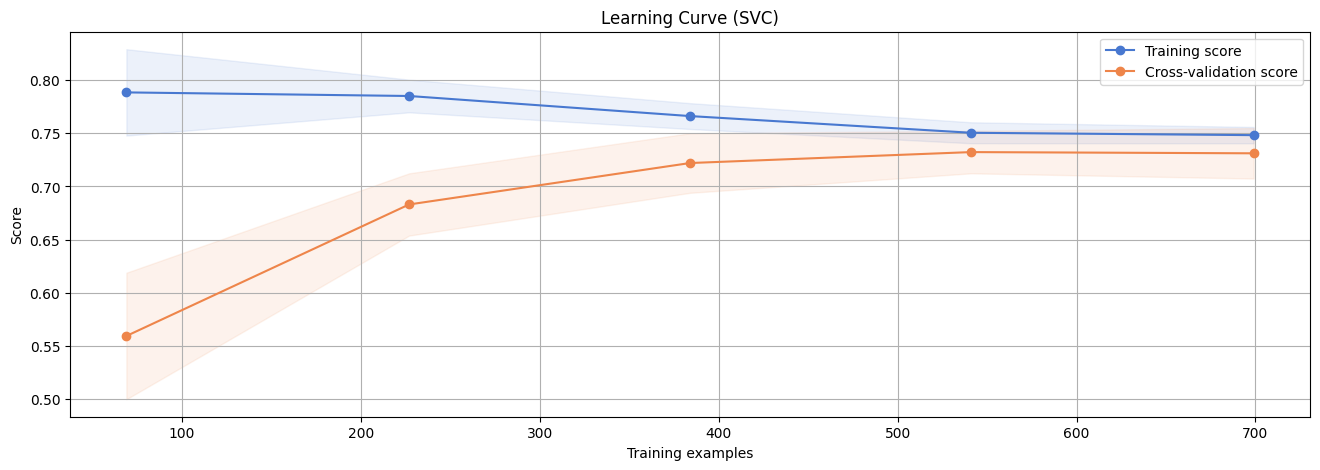

In [44]:
my.plot_learning_curve(svc, "Learning Curve (SVC)", scaled_X_train, y_train, cv=5)
plt.show()

From the learning curve above, it seems that the SVC model is not overfitted. From the Confusion Matrix below, it seems as the model is mostly struggling with False Negatives. Based on **Recall** values for class 1, this is an issue in all algorithms that we have used so far.


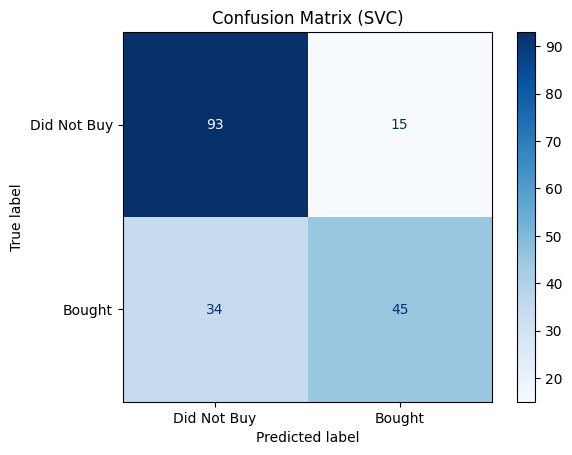

In [45]:
cm = confusion_matrix(y_validation, yhat_validation)

cmd = ConfusionMatrixDisplay(cm, display_labels=["Did Not Buy", "Bought"])

cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (SVC)")
plt.show()

In [46]:
model_performance_df.sort_values(by="Accuracy", ascending=False)

,Name,Accuracy,Macro Avg F1,F1 Score Class 1,Precision Class 1,Recall Class 1
7,SVC,0.737968,0.719486,0.647482,0.750000,0.569620
3,Decision Tree,0.732620,0.703061,0.609375,0.795918,0.493671
4,Random Forest,0.732620,0.700781,0.603175,0.808511,0.481013
5,kNN,0.732620,0.705233,0.615385,0.784314,0.506329
6,Linear SVC,0.679144,0.667496,0.605263,0.630137,0.582278
2,Logistic Regression,0.673797,0.627381,0.495868,0.714286,0.379747
0,Majority Class,0.577540,0.366102,0.000000,0.000000,0.000000
1,Proportions,0.508021,0.494119,0.410256,0.415584,0.405063


Aftert some parameter tunning, it seems that Support Vector Machine Classifier performs best. **Decision Tree**, **Random Forest** and **kNN** seem to have similar performances, however, their performance on the training data was noticeably better than for the validation test, so they were likely overfitting. Moreove, their **f1-scores** for class 1 is lower.

Nevertheless, we will try creating an Ensemble model to see if we can get better results than our SVC.


### 4.3. Ensemble Model


In [47]:
logreg = LogisticRegression()
random_forest = RandomForestClassifier()
knn = KNeighborsClassifier(n_neighbors=8)
svc2 = SVC(kernel="rbf", gamma="auto", C=0.7, class_weight="balanced", probability=True)


ensemble = VotingClassifier(
    estimators=[
        ("logreg", logreg),
        ("random_forest", random_forest),
        ("knn", knn),
        ("svc", svc2),
    ],
    voting="soft",
)

ensemble.fit(scaled_X_train, y_train)

yhat_train_ensemble = ensemble.predict(scaled_X_train)
yhat_validation_ensemble = ensemble.predict(scaled_X_validation)

print(
    f"Ensemble Training accuracy:   {accuracy_score(y_train, yhat_train_ensemble):.6f}"
)
print(
    f"Ensemble Validation accuracy: {accuracy_score(y_validation, yhat_validation_ensemble):.6f}"
)
print("Ensemble Training data:\n", classification_report(y_train, yhat_train_ensemble))
print(
    "Ensemble Validation data:\n",
    classification_report(y_validation, yhat_validation_ensemble),
)

Ensemble Training accuracy:   0.791762
Ensemble Validation accuracy: 0.737968
Ensemble Training data:
               precision    recall  f1-score   support

           0       0.76      0.95      0.85       532
           1       0.88      0.54      0.67       342

    accuracy                           0.79       874
   macro avg       0.82      0.75      0.76       874
weighted avg       0.81      0.79      0.78       874

Ensemble Validation data:
               precision    recall  f1-score   support

           0       0.73      0.88      0.79       108
           1       0.77      0.54      0.64        79

    accuracy                           0.74       187
   macro avg       0.75      0.71      0.72       187
weighted avg       0.74      0.74      0.73       187



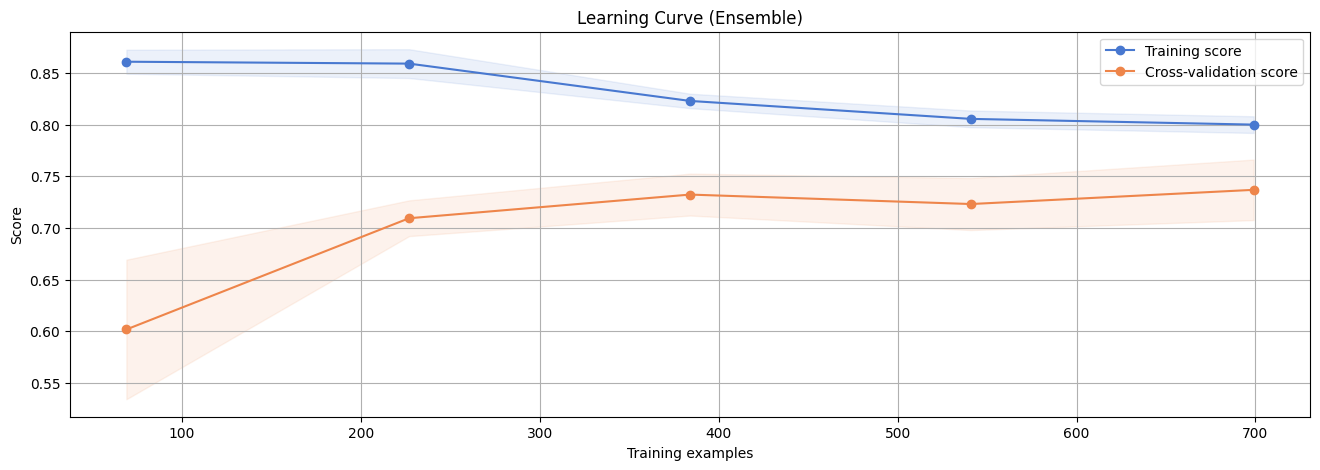

In [48]:
my.plot_learning_curve(
    ensemble, "Learning Curve (Ensemble)", scaled_X_train, y_train, cv=5
)
plt.show()

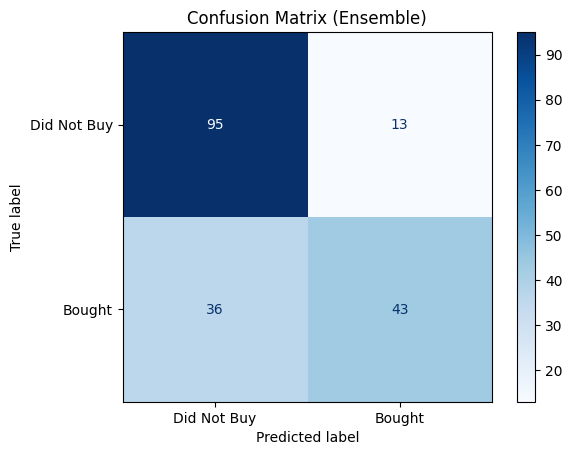

In [49]:
cm = confusion_matrix(y_validation, yhat_validation_ensemble)

cmd = ConfusionMatrixDisplay(cm, display_labels=["Did Not Buy", "Bought"])

cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Ensemble)")
plt.show()

Ensemble model performs slighlty worse than our SCV model. Therefore, we will be using our SVC model as the final model on our training dataset.


### 4.4. Evaluating Final Model (SVC)


In [50]:
yhat_test = svc.predict(scaled_X_test)

model_name = "SVC"
print(model_name)
print(f"Test accuracy:   {accuracy_score(y_test, yhat_test):.6f}")
print("Testing data:\n", classification_report(y_test, yhat_test))

SVC
Test accuracy:   0.760638
Testing data:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83       126
           1       0.67      0.55      0.60        62

    accuracy                           0.76       188
   macro avg       0.73      0.71      0.72       188
weighted avg       0.75      0.76      0.75       188



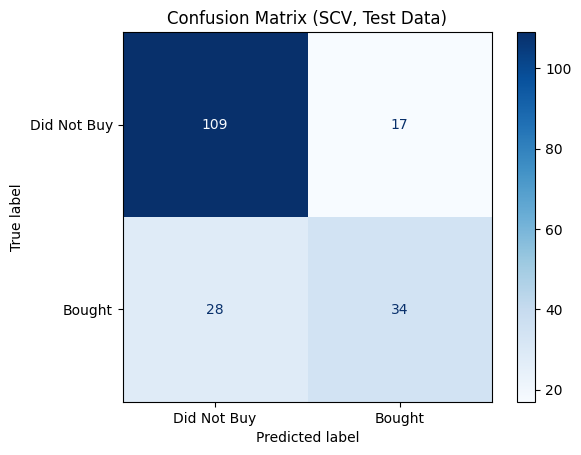

In [51]:
cm = confusion_matrix(y_test, yhat_test)

cmd = ConfusionMatrixDisplay(cm, display_labels=["Did Not Buy", "Bought"])

cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (SCV, Test Data)")
plt.show()

Fortunately, we get even higher accuracy for our testing dataset at 76%. F1 score is lower for class 1, so the model could still be improved, especially when dealing with False Negatives.


## 5. Conclusions


**Exploratory Data Analysis**:

- In 2019, we tried selling the new travel insurance to almost 2000 customers. Based on our sample, our target clientele was of the following features:
  - age of 25-35 years;
  - ~30% working in the Government sector, while the 70% were working in the Private Sector or were self-employed;
  - Majority (~83%) were College graduates;
  - Average annual income of ~935'000 Rupees;
  - 32.6% had at least one chronic disease;
  - 23% were frequent flyers;
  - Only ~20% have ever travelled abroad.
- From our sample, our conversion rate was ~39%.

- Purchasers of our Travel Insurance were more likely to:
  - work in private sector or be self-employed
  - have higher annual income
  - be frequent flyers
  - have ever travelled abroad.

**Statistical Inference**:

- **H1**. Null Hypothesis was **rejected**. Customers who have ever travelled abroad have higher annual income by 45%.
- **H2**. **Failed to Reject** Null Hypothesis. There is no statistically significant difference in mean age of customers who have and don’t have chronic diseases (Age range 25-35).

**Prediction Models**:

- We used the **Support Vector Machine Classifier** as our final model.
- On our test dataset, we reached an _accuracy_ of **76%** and _f1 score_ of **0.60** for class 1.
- To improve the predictions model in the future, _recall_ for class 1 should be improved.


**Potential Improvements** (a.k.a. future work ):

- Oversampling (bootstrapping) was tried, and in most cases it lead to oferfitting when comparing results of training and validation sets. SMOTE sampling technique might yield different results.
- Boosting could be used to overcome prediction models weakness with False Negatives.
- More attention to Feature Selection and Feature Engineering could lead to differnt results.
